# Orientation Analysis Plot (Polar coordinates)

In [95]:
# Import required modules

import pandas as pd

import matplotlib.pyplot as plt 

import seaborn as sns

import math

import re 

import pathlib

from pathlib import Path

import scipy

from scipy.signal import savgol_filter

import numpy as np

import matplotlib.gridspec as gridspec


plt.rcParams['svg.fonttype'] = 'none'

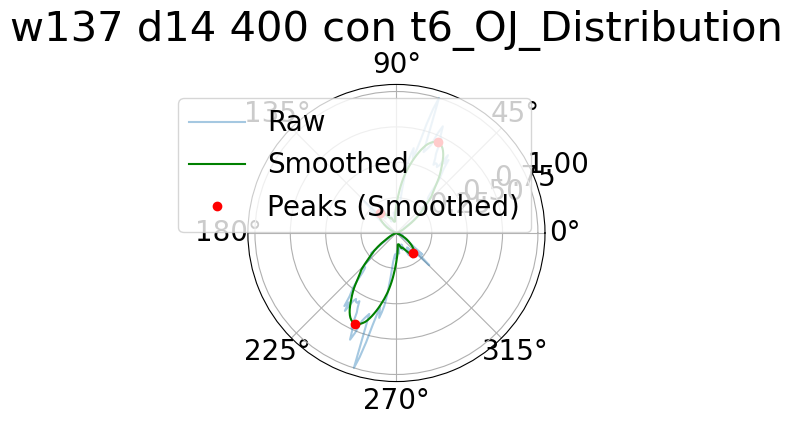

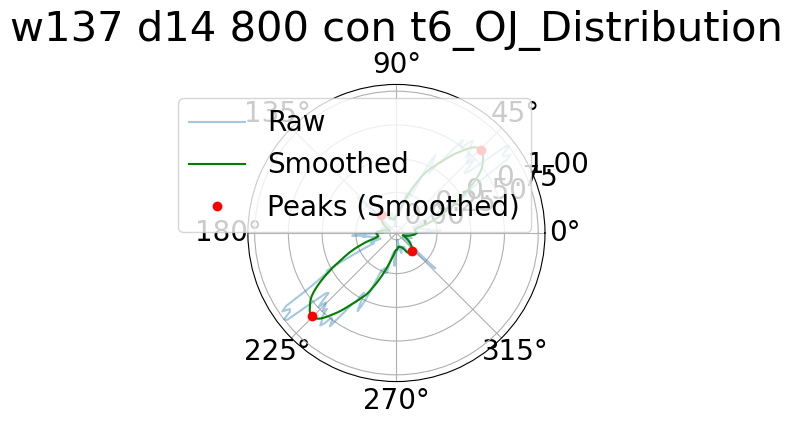

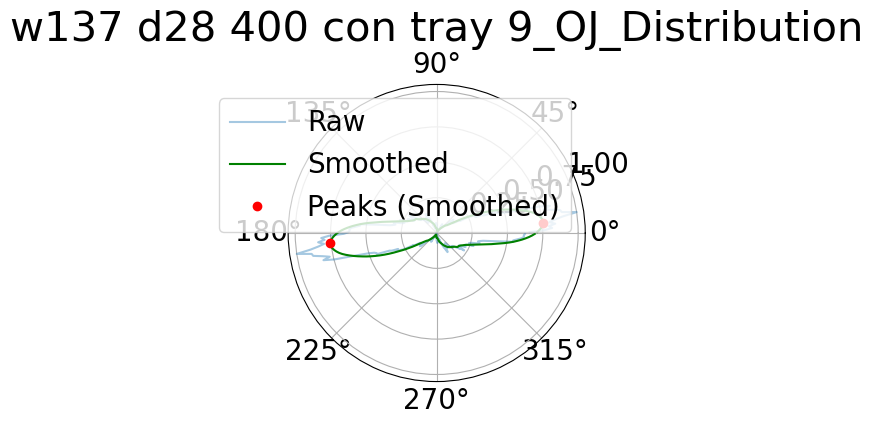

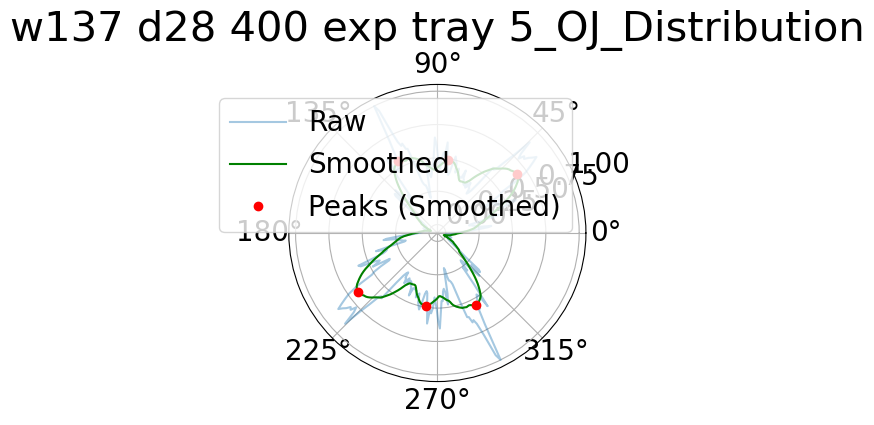

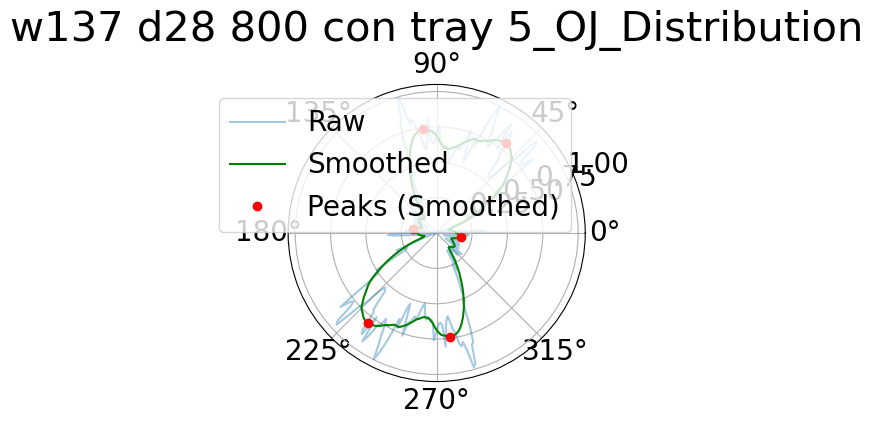

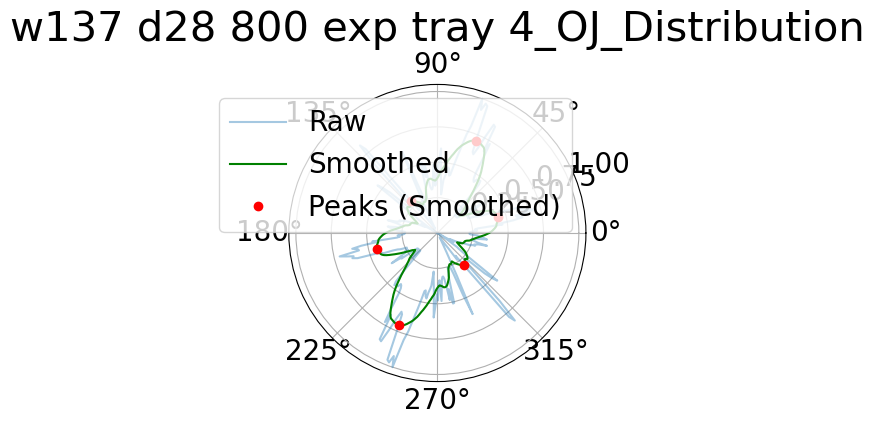

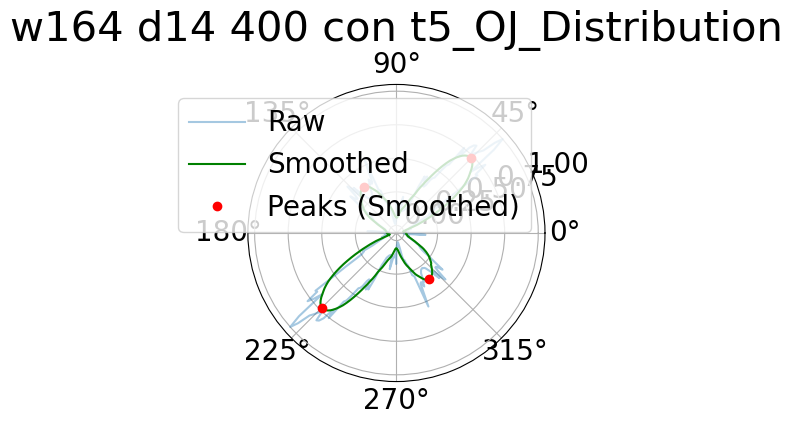

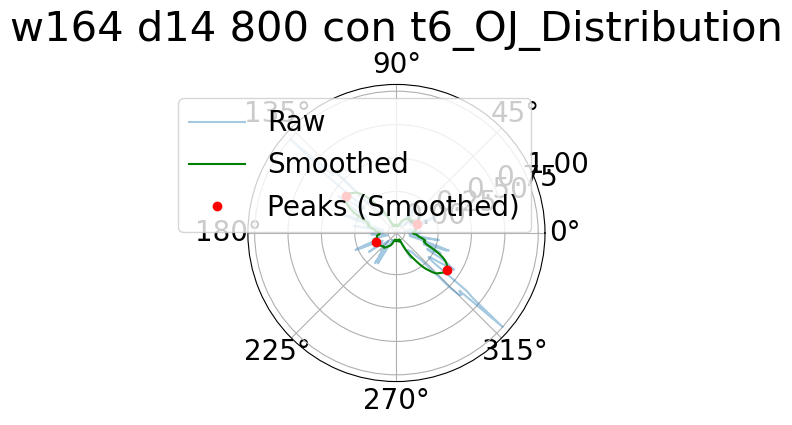

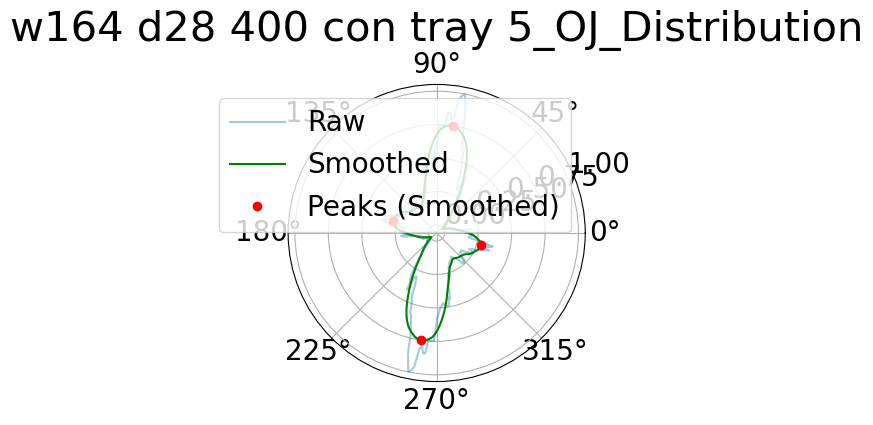

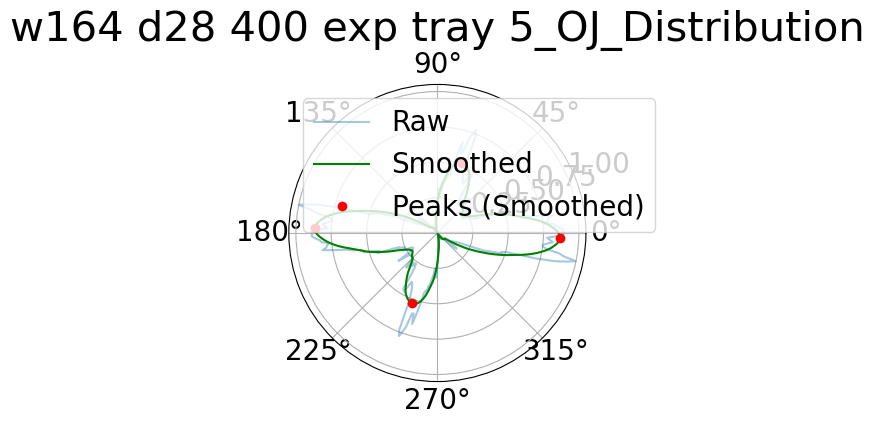

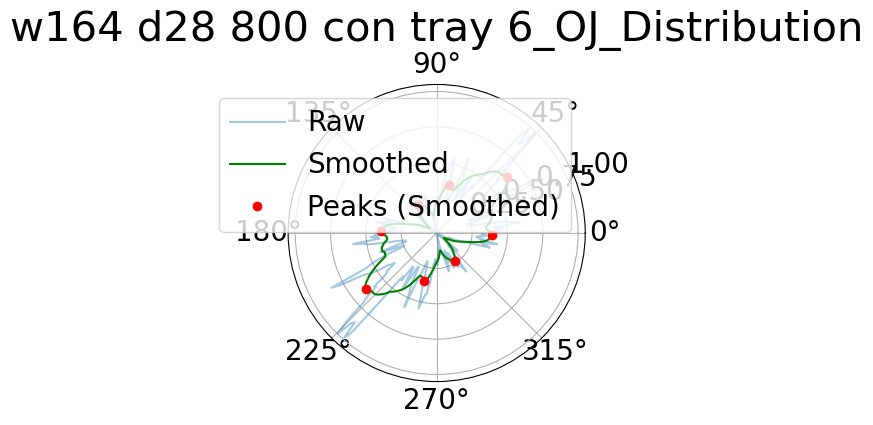

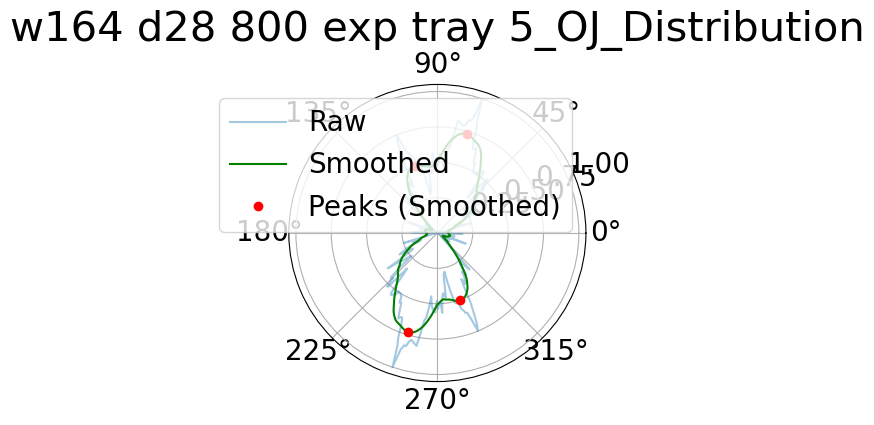

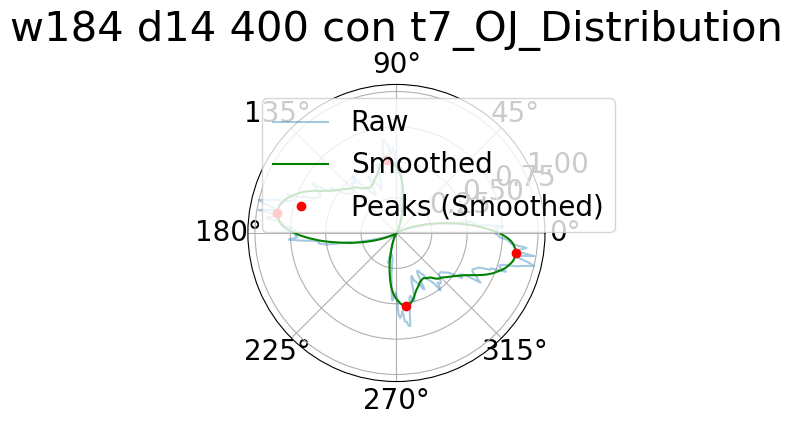

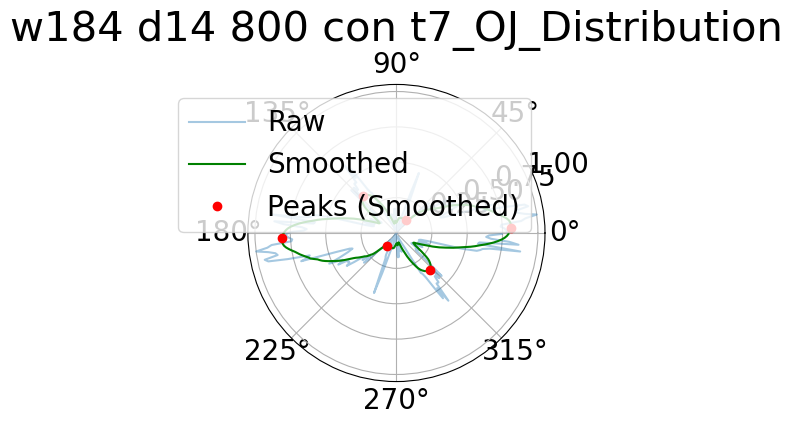

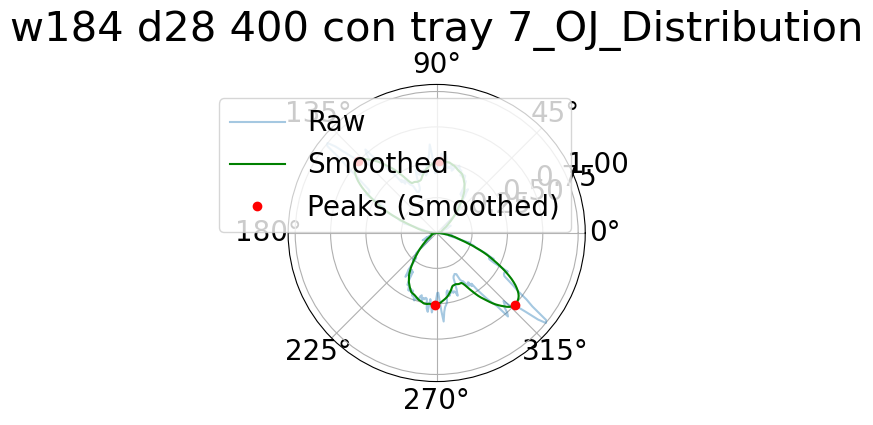

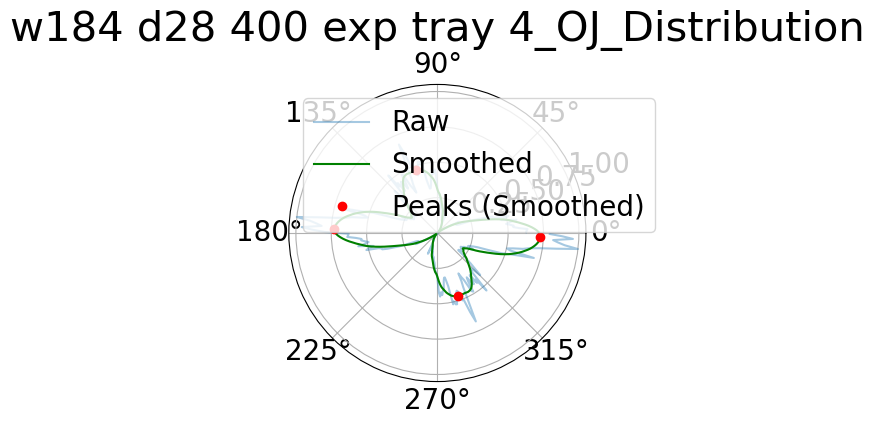

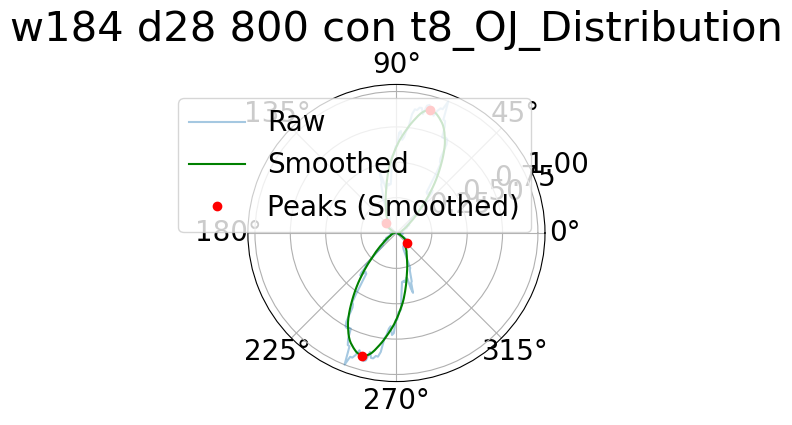

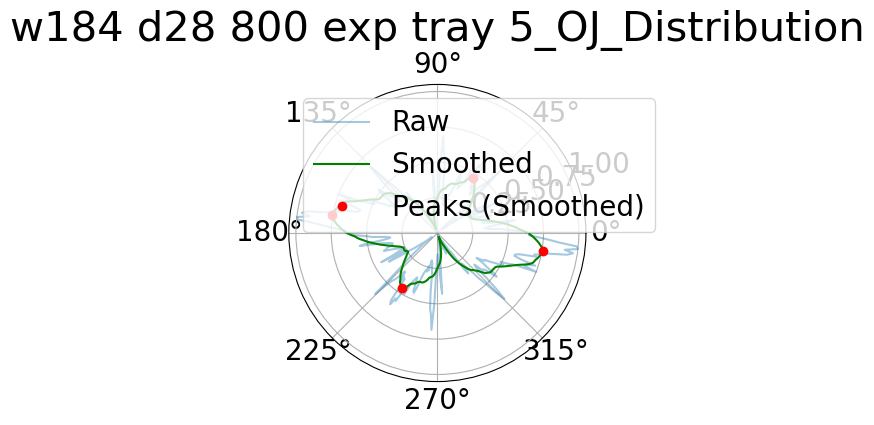

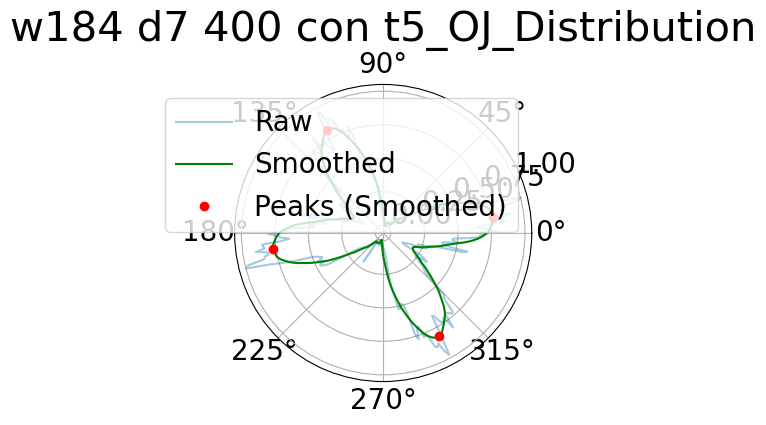

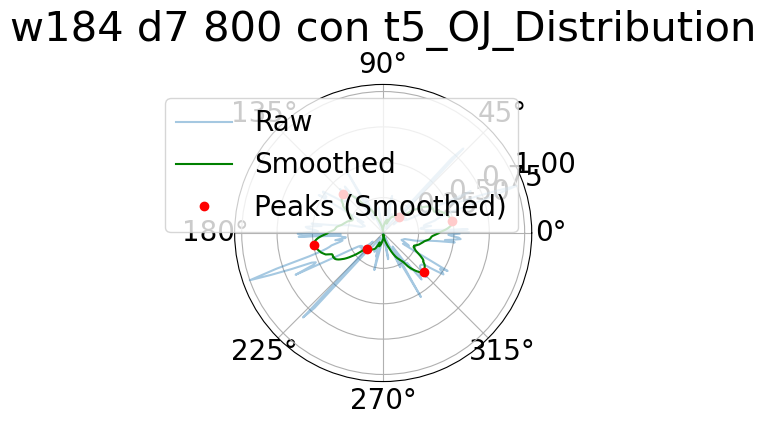

In [112]:
# Import data from filepath

folder_path = Path(r"C:\Users\mbgm4fs3\OneDrive - The University of Manchester\PhD\Experimental\Data\5. Mechanical Stimulation\Primary\Imaging\Pic Red\analysed")

for csv_file in folder_path.glob("*.csv"):

    title = csv_file.stem

    # read in csv file
    df = pd.read_csv(csv_file)

    # df is from -90 to 90, but we want from 0 to 360 to ensure all peaks within datarange
    # first add 90 to original df make it from 0 to 180
    df['Orientation'] += 90

    # Create a second copy shifted from [0, 180] → [180, 360]
    df_copy = df.assign(Orientation=df['Orientation'] + 180)     

    # append second half of circular data to first to get 360 degree data
    df_circular = pd.concat([df, df_copy], ignore_index=True)

    # now lets extend the data -180 and +180 to avoid artefacts when smoothing
    # Assume df has 'Orientation' from 0 to 360 and 'Signal'
    df_extended = pd.concat([df_circular.assign(Orientation=df_circular['Orientation'] - 360), 
                             df_circular, 
                             df_circular.assign(Orientation=df_circular['Orientation'] + 360)], 
                             ignore_index=True)

    # calculate orientation in radians
    df_extended['Orientation_rad'] = df_extended['Orientation'] * (math.pi / 180) 

    # normalise data 
    Slice1_min = df_extended['Slice1'].min()
    Slice1_max = df_extended['Slice1'].max()

    df_extended['Slice1_norm'] = (df_extended['Slice1'] - Slice1_min)/(Slice1_max - Slice1_min)

    # smooth signal
    df_extended['Slice1_smooth'] = savgol_filter(df_extended['Slice1_norm'], 50, 2)

    # Trim back to the original 0–360 range
    df_trimmed = df_extended[(df_extended['Orientation'] >= 0) & (df_extended['Orientation'] <= 360)].reset_index(drop=True)


    # find peaks from data
    # compare find_peaks of smoothed data, to find_peaks_cwt of raw data
    # find peaks in smoothed signal
    peaks, props = scipy.signal.find_peaks(df_trimmed['Slice1_smooth'], distance=35, height=0.1)

    # Set up plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    # Plot raw signal
    ax.plot(df_trimmed['Orientation_rad'], df_trimmed['Slice1_norm'], label='Raw', alpha=0.4)

    # Plot smoothed signal
    ax.plot(df_trimmed['Orientation_rad'], df_trimmed['Slice1_smooth'], label='Smoothed', color='green')

    # Plot peaks from smoothed signal
    ax.plot(df_trimmed['Orientation_rad'].iloc[peaks],
            df_trimmed['Slice1_smooth'].iloc[peaks],
            'ro', label='Peaks (Smoothed)')

    # Decorations
    ax.set_title(title)
#     ax.set_xlabel('Orientation (Degrees)')
#     ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True)

    # Save the figure as SVG
    plt.tight_layout()
    plt.savefig(f'{title}.svg', format='svg')


   

In [117]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import math
import scipy.signal
from scipy.signal import savgol_filter
import matplotlib as mpl
from scipy.stats import circmean, circstd

# Set matplotlib parameters for better visualization
mpl.rcParams['font.size'] = 25
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 20

# Import data from filepath
folder_path = Path(r"C:\Users\mbgm4fs3\OneDrive - The University of Manchester\PhD\Experimental\Data\5. Mechanical Stimulation\Primary\Imaging\Pic Red\analysed")

# Create a DataFrame to store the Fourier analysis results
results_df = pd.DataFrame(columns=['Filename', 'NumPeaks', 'H2_Amplitude', 'H4_Amplitude', 
                                  'H4_to_H2_Ratio', 'DominantHarmonic', 
                                  'FirstHalfMeanAngle', 'FirstHalfNumPeaks'])

for csv_file in folder_path.glob("*.csv"):
    title = csv_file.stem
    print(f"Processing {title}...")

    # read in csv file
    df = pd.read_csv(csv_file)

    # df is from -90 to 90, but we want from 0 to 360 to ensure all peaks within datarange
    # first add 90 to original df make it from 0 to 180
    df['Orientation'] += 90

    # Create a second copy shifted from [0, 180] → [180, 360]
    df_copy = df.assign(Orientation=df['Orientation'] + 180)     

    # append second half of circular data to first to get 360 degree data
    df_circular = pd.concat([df, df_copy], ignore_index=True)

    # now lets extend the data -180 and +180 to avoid artefacts when smoothing
    df_extended = pd.concat([df_circular.assign(Orientation=df_circular['Orientation'] - 360), 
                             df_circular, 
                             df_circular.assign(Orientation=df_circular['Orientation'] + 360)], 
                             ignore_index=True)

    # calculate orientation in radians
    df_extended['Orientation_rad'] = df_extended['Orientation'] * (math.pi / 180) 

    # normalise data 
    Slice1_min = df_extended['Slice1'].min()
    Slice1_max = df_extended['Slice1'].max()

    df_extended['Slice1_norm'] = (df_extended['Slice1'] - Slice1_min)/(Slice1_max - Slice1_min)

    # smooth signal
    df_extended['Slice1_smooth'] = savgol_filter(df_extended['Slice1_norm'], 50, 2)

    # Trim back to the original 0–360 range
    df_trimmed = df_extended[(df_extended['Orientation'] >= 0) & (df_extended['Orientation'] <= 360)].reset_index(drop=True)

    # find peaks from data
    peaks, props = scipy.signal.find_peaks(df_trimmed['Slice1_smooth'], distance=35, height=0.1)
    num_peaks = len(peaks)
    
    # -----------------------------------------
    # Calculate angles between peaks - ONLY FIRST HALF (0-180°)
    # -----------------------------------------
    peak_angles_deg = df_trimmed['Orientation'].iloc[peaks].values
    
    # Filter to only include peaks in the first half (0-180°)
    first_half_peaks = peak_angles_deg[(peak_angles_deg >= 0) & (peak_angles_deg <= 180)]
    first_half_peaks = np.sort(first_half_peaks)
    first_half_num_peaks = len(first_half_peaks)
    
    # Calculate angular differences between consecutive peaks in first half
    first_half_angle_diffs = []
    if first_half_num_peaks >= 2:
        for i in range(first_half_num_peaks-1):
            diff = first_half_peaks[i+1] - first_half_peaks[i]
            first_half_angle_diffs.append(diff)
        
        first_half_mean_angle = np.mean(first_half_angle_diffs)
    else:
        first_half_mean_angle = np.nan

    # -----------------------------------------
    # Fourier Analysis to assess the circular pattern
    # -----------------------------------------
    
    # Resample the signal to have uniform angular spacing for FFT
    angles = np.linspace(0, 2*np.pi, 360)
    # Interpolate the smoothed data to uniform angular spacing
    signal_interp = np.interp(angles, df_trimmed['Orientation_rad'], df_trimmed['Slice1_smooth'])
    
    # Apply Fourier Transform
    fft_result = np.fft.fft(signal_interp)
    fft_amplitude = np.abs(fft_result)
    
    # The 2nd harmonic corresponds to 2 cycles in 360 degrees (index 2 in FFT)
    # The 4th harmonic corresponds to 4 cycles in 360 degrees (index 4 in FFT)
    h2_amplitude = fft_amplitude[2] / len(angles)  # Normalize by signal length
    h4_amplitude = fft_amplitude[4] / len(angles)
    
    # Calculate ratio of 4th to 2nd harmonic
    h4_to_h2_ratio = h4_amplitude / h2_amplitude if h2_amplitude > 0 else float('inf')
    
    # Determine dominant harmonic
    dominant_harmonic = 4 if h4_amplitude > h2_amplitude else 2
    
    # Store results
    results_df = pd.concat([results_df, pd.DataFrame({
        'Filename': [title],
        'NumPeaks': [num_peaks],
        'H2_Amplitude': [h2_amplitude],
        'H4_Amplitude': [h4_amplitude],
        'H4_to_H2_Ratio': [h4_to_h2_ratio],
        'DominantHarmonic': [dominant_harmonic],
        'FirstHalfMeanAngle': [first_half_mean_angle],
        'FirstHalfNumPeaks': [first_half_num_peaks]
    })], ignore_index=True)

    # -----------------------------------------
    # Visualization
    # -----------------------------------------
    
    # Create a figure with 2 subplots: polar plot and FFT spectrum
    fig = plt.figure(figsize=(21, 9))

    # adjust relative widths of each subplot
    gs = gridspec.GridSpec(1, 2, width_ratios=[6, 1])  # wide : narrow

    
    # Polar plot for the circular data
    # need to use add_subplot as both plots require different axis (polar and cartisean)
    ax1 = fig.add_subplot(gs[0], projection='polar')
    ax1.plot(df_trimmed['Orientation_rad'], df_trimmed['Slice1_norm'], label='Raw', alpha=0.6)
    ax1.plot(df_trimmed['Orientation_rad'], df_trimmed['Slice1_smooth'], label='Smoothed', color='green')
    
    # Plot all peaks
    ax1.plot(df_trimmed['Orientation_rad'].iloc[peaks],
            df_trimmed['Slice1_smooth'].iloc[peaks],
            'ro', label=f'Peaks')
            
    ax1.set_title(f"{title}\nDominant Harmonic: {dominant_harmonic}")
    ax1.legend(loc='lower left', framealpha=0.5)
    # ax1.legend()
    ax1.grid(True)
    ax1.set_thetamin(0)
    ax1.set_thetamax(180)

    # FFT spectrum plot
    ax2 = fig.add_subplot(gs[1])
    # Only plot the first 10 harmonics (0-9)
    harmonic_indices = [2, 4]
    harmonic_amplitudes = fft_amplitude[[2, 4]] / len(angles)


    # Reindex bars to be plotted at [0, 1] instead of [2, 4]
    bar_positions = range(len(harmonic_indices))  # [0, 1]
    ax2.bar(bar_positions, harmonic_amplitudes, color=('gold', 0.5), edgecolor=('black', 1))
    ax2.set_xticks(bar_positions)
    ax2.set_xticklabels(harmonic_indices)  # Labels still show "2" and "4"
    ax2.set_xlabel('Harmonic')
    ax2.set_ylabel('Amplitude')
    ax2.set_title(f'FFT Spectrum\nH4:H2 Ratio = {h4_to_h2_ratio:.2f}', pad=100)
    
    # Add a text box with the analysis results
    if np.isnan(first_half_mean_angle):
        angle_text = "Only one main orientation"
    else:
        angle_text = f"Angle between peaks: {first_half_mean_angle:.1f}"
        
    textstr = (f'2nd Harmonic: {h2_amplitude:.4f}\n'
               f'4th Harmonic: {h4_amplitude:.4f}\n'
               f'Ratio (H4/H2): {h4_to_h2_ratio:.2f}\n'
               f'Orientation peaks: {first_half_num_peaks}\n'
               f'{angle_text}')
               
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    # ax2.text(0.95, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
    #         verticalalignment='top', horizontalalignment='right', bbox=props)
    ax2.text(0.95, 0.95, textstr, transform=ax2.transAxes, fontsize=20, bbox=props,
        va='top', ha='left')

    plt.tight_layout()
    plt.savefig(f'{title}_with_fft.svg', format='svg')
    plt.close()

# Save the results to a CSV file
results_df.to_csv('harmonic_analysis_results.csv', index=False)

# Create summary plot showing the distribution of harmonic ratios
plt.figure(figsize=(12, 8))

# Create a 2x2 subplot grid
plt.subplot(2, 2, 1)
plt.hist(results_df['H4_to_H2_Ratio'].clip(0, 5), bins=20, edgecolor='black')
plt.axvline(x=1.0, color='r', linestyle='--', label='H4 = H2')
plt.xlabel('H4/H2 Ratio (clipped at 5)')
plt.ylabel('Frequency')
plt.title('Distribution of H4/H2 Ratios')
plt.grid(True, alpha=0.3)
plt.legend()

# Create a scatter plot of number of peaks vs harmonic ratio
plt.subplot(2, 2, 2)
plt.scatter(results_df['NumPeaks'], results_df['H4_to_H2_Ratio'].clip(0, 5), alpha=0.7)
plt.axhline(y=1.0, color='r', linestyle='--', label='H4 = H2')
plt.xlabel('Number of Detected Peaks')
plt.ylabel('H4/H2 Ratio (clipped at 5)')
plt.title('Number of Peaks vs. Harmonic Ratio')
plt.grid(True, alpha=0.3)
plt.legend()

# Create histogram of average angle between first-half peaks
plt.subplot(2, 2, 3)
# Filter out NaN values before plotting
valid_angles = results_df['FirstHalfMeanAngle'].dropna()
if len(valid_angles) > 0:
    plt.hist(valid_angles, bins=18, range=(0, 90), edgecolor='black')
    plt.axvline(x=45, color='g', linestyle='--', label='45° - Ideal for 4-fold')
    plt.axvline(x=90, color='b', linestyle='--', label='90° - Ideal for 2-fold')
    plt.xlabel('Mean Angle Between First-Half Peaks (degrees)')
    plt.ylabel('Frequency')
    plt.title('Distribution of First-Half Peak Spacing')
    plt.grid(True, alpha=0.3)
    plt.legend()
else:
    plt.text(0.5, 0.5, "No valid angle data", ha='center', va='center')

# Create scatter plot of first-half mean angle vs H4/H2 ratio
plt.subplot(2, 2, 4)
# Only plot points with valid angle data
mask = ~results_df['FirstHalfMeanAngle'].isna()
if mask.sum() > 0:
    plt.scatter(results_df.loc[mask, 'FirstHalfMeanAngle'], 
                results_df.loc[mask, 'H4_to_H2_Ratio'].clip(0, 5), 
                alpha=0.7)
    plt.axhline(y=1.0, color='r', linestyle='--', label='H4 = H2')
    plt.axvline(x=45, color='g', linestyle='--', label='45° spacing')
    plt.axvline(x=90, color='b', linestyle='--', label='90° spacing')
    plt.xlabel('Mean Angle Between First-Half Peaks (degrees)')
    plt.ylabel('H4/H2 Ratio (clipped at 5)')
    plt.title('First-Half Peak Spacing vs. Harmonic Ratio')
    plt.grid(True, alpha=0.3)
    plt.legend()
else:
    plt.text(0.5, 0.5, "No valid data to plot", ha='center', va='center')

plt.tight_layout()
plt.savefig('first_half_peak_analysis_summary.svg', format='svg')
plt.close()

print("Analysis complete!")
print(f"Total samples analyzed: {len(results_df)}")
print(f"Samples with dominant 2nd harmonic: {sum(results_df['DominantHarmonic'] == 2)}")
print(f"Samples with dominant 4th harmonic: {sum(results_df['DominantHarmonic'] == 4)}")

# Summary statistics for peak spacing
valid_angles = results_df['FirstHalfMeanAngle'].dropna()
if len(valid_angles) > 0:
    print("\nFirst-half peak spacing statistics:")
    print(f"Average first-half peak spacing: {valid_angles.mean():.2f}° ± {valid_angles.std():.2f}°")
    
    # Count samples close to ideal spacing
    near_45 = sum((valid_angles > 40) & (valid_angles < 50))
    near_90 = sum((valid_angles > 85) & (valid_angles < 95))
    print(f"Samples with ~45° first-half spacing (4-fold pattern): {near_45} ({near_45/len(valid_angles)*100:.1f}%)")
    print(f"Samples with ~90° first-half spacing (2-fold pattern): {near_90} ({near_90/len(valid_angles)*100:.1f}%)")

Processing w137 d14 400 con t6_OJ_Distribution...


C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_23200\3567788281.py:115: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


Processing w137 d14 800 con t6_OJ_Distribution...
Processing w137 d28 400 con tray 9_OJ_Distribution...
Processing w137 d28 400 exp tray 5_OJ_Distribution...
Processing w137 d28 800 con tray 5_OJ_Distribution...
Processing w137 d28 800 exp tray 4_OJ_Distribution...
Processing w164 d14 400 con t5_OJ_Distribution...
Processing w164 d14 800 con t6_OJ_Distribution...
Processing w164 d28 400 con tray 5_OJ_Distribution...
Processing w164 d28 400 exp tray 5_OJ_Distribution...
Processing w164 d28 800 con tray 6_OJ_Distribution...
Processing w164 d28 800 exp tray 5_OJ_Distribution...
Processing w184 d14 400 con t7_OJ_Distribution...
Processing w184 d14 800 con t7_OJ_Distribution...
Processing w184 d28 400 con tray 7_OJ_Distribution...
Processing w184 d28 400 exp tray 4_OJ_Distribution...
Processing w184 d28 800 con t8_OJ_Distribution...
Processing w184 d28 800 exp tray 5_OJ_Distribution...
Processing w184 d7 400 con t5_OJ_Distribution...
Processing w184 d7 800 con t5_OJ_Distribution...
Analysis

# Plot all data on same graph 

C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_8808\2659636563.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect to make room for the colorbar


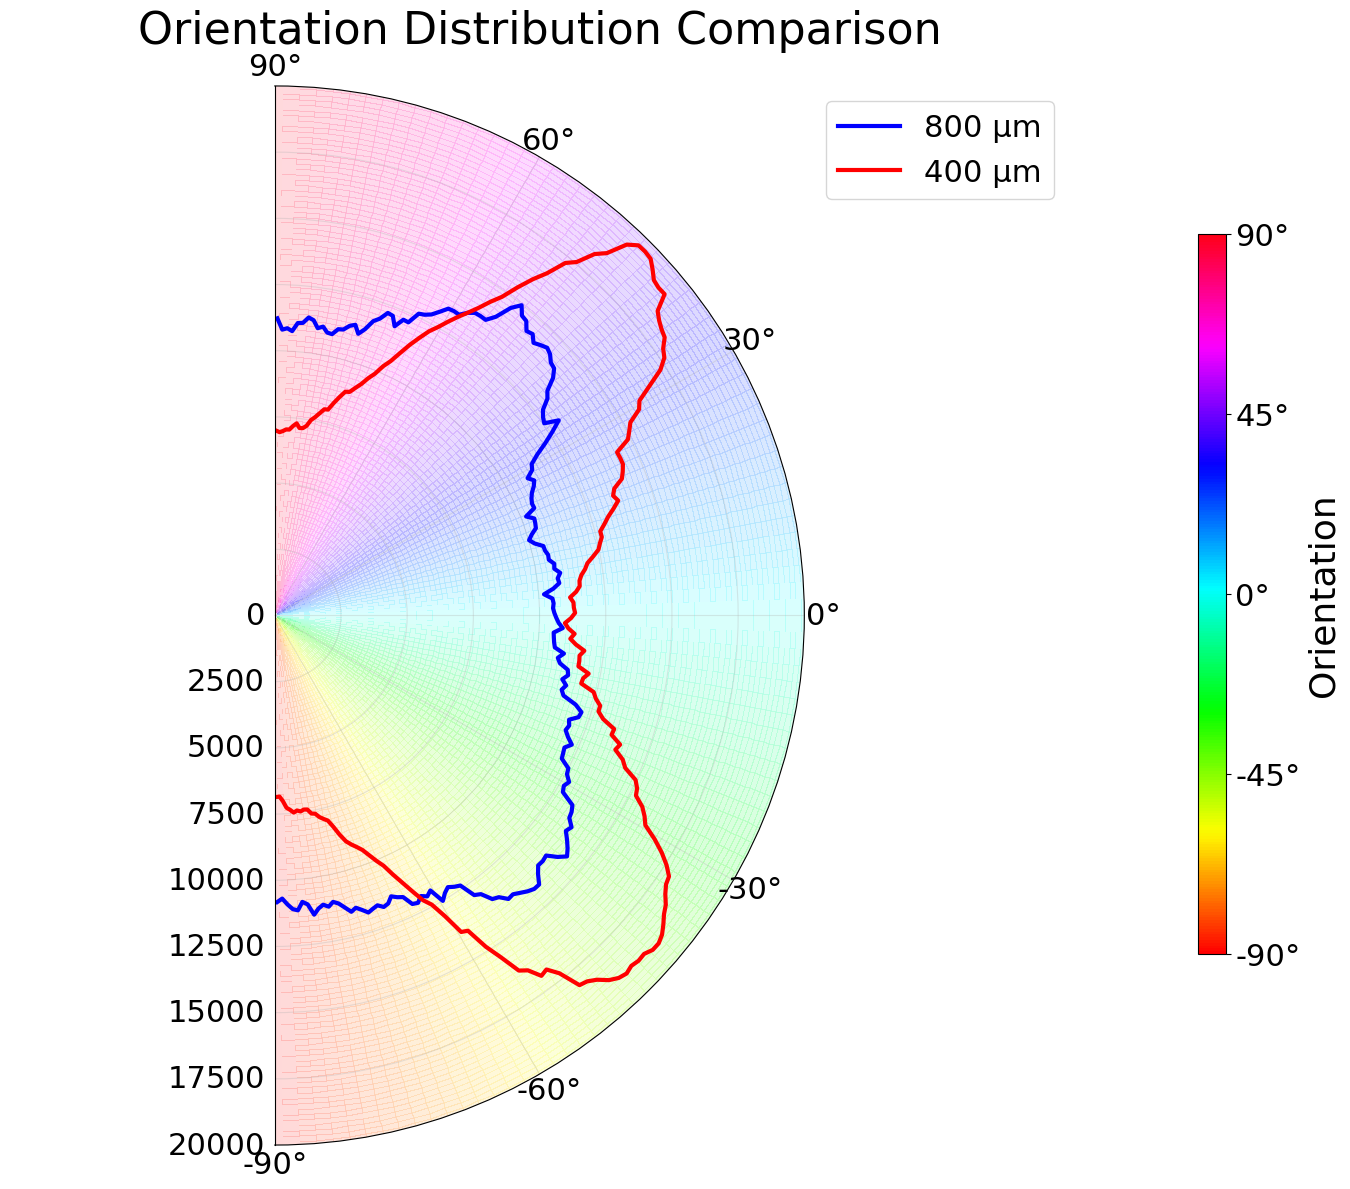

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math

# Import data from filepath
df = pd.read_csv(r'C:\Users\mbgm4fs3\OneDrive - The University of Manchester\PhD\Experimental\Data\3. Static Culture\Y201\OrientationJ\800d28y201_orientation_distribution.csv')
df['Direction'] = df['Direction'] * (math.pi / 180)

df_400 = pd.read_csv(r'C:\Users\mbgm4fs3\OneDrive - The University of Manchester\PhD\Experimental\Data\3. Static Culture\Y201\OrientationJ\400d28y201_orientation_distribution.csv')
df_400['Direction'] = df_400['Direction'] * (math.pi / 180)

# Create a function to generate the OrientationJ-style colormap background
def add_orientation_colormap(ax, rmax):
    # Create a meshgrid for the background
    r = np.linspace(0, rmax, 100)
    theta = np.linspace(-np.pi/2, np.pi/2, 100)
    R, T = np.meshgrid(r, theta)
    
    # Normalize angles from [-pi/2, pi/2] to [0, 1] for HSV
    norm_angle = (T + np.pi/2) / np.pi
    
    # Create a custom colormap based on HSV
    hsv_cmap = plt.cm.hsv
    
    # Plot the background with the HSV colormap
    im = ax.pcolormesh(T, R, norm_angle, cmap=hsv_cmap, alpha=0.15, shading='auto')
    
    return ax

# Create a single polar plot
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='polar')

# Set font sizes
title_fontsize = 32
label_fontsize = 26
tick_fontsize = 22
legend_fontsize = 22

# Set rmax value (adjust as needed based on your data)
rmax = 20000

# Add the orientation colormap background
add_orientation_colormap(ax, rmax)

# Plot both datasets on the same plot with different colors and line styles
ax.plot(df['Direction'], df['Frequency'], linewidth=3, color='blue', label='800 μm')
ax.plot(df_400['Direction'], df_400['Frequency'], linewidth=3, color='red', label='400 μm')

# Set the theta and r limits
ax.set_thetamin(-90)
ax.set_thetamax(90)
ax.set_rmin(0)
ax.set_rmax(rmax)

# Add grid, title, and other formatting
ax.grid(alpha=0.3)
ax.set_title('Orientation Distribution Comparison', fontsize=title_fontsize)
ax.tick_params(labelsize=tick_fontsize)

# Add a legend
ax.legend(fontsize=legend_fontsize, loc='upper right')

# Add a colorbar to show angle-to-color mapping
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
cb = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.hsv), cax=cbar_ax)
cb.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
cb.set_ticklabels(['-90°', '-45°', '0°', '45°', '90°'])
cb.ax.tick_params(labelsize=tick_fontsize)
cb.set_label('Orientation', fontsize=label_fontsize)

# Save the figure
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect to make room for the colorbar
plt.savefig('combined_polar_plot.svg', format='svg')
plt.savefig('combined_polar_plot.png', format='png', dpi=300)

# Optional: display the plot in an interactive session
# plt.show()